In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR


import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm

from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv,GraphConv, ChebConv
from torch_geometric.data import Data

import pyproj

PROJ = pyproj.Proj(proj='stere',  a=6378273, b=6378273, lon_0=-45, lat_0=90, lat_ts=90)

##Adding src path to get our code
import sys
sys.path.append('../src')
from ice_graph.ice_graph import Nextsim_data, Ice_graph
from utils.graph_utils import standardize_graph_features
from models.training_utils import process_dataloader

## Sea Ice ML - Training and data handling example

Here it is presented how to create custom graphs centered on neXTSIM elements, convert them into pytorch geometric data classes and train a simple GNN to predict trajectories.

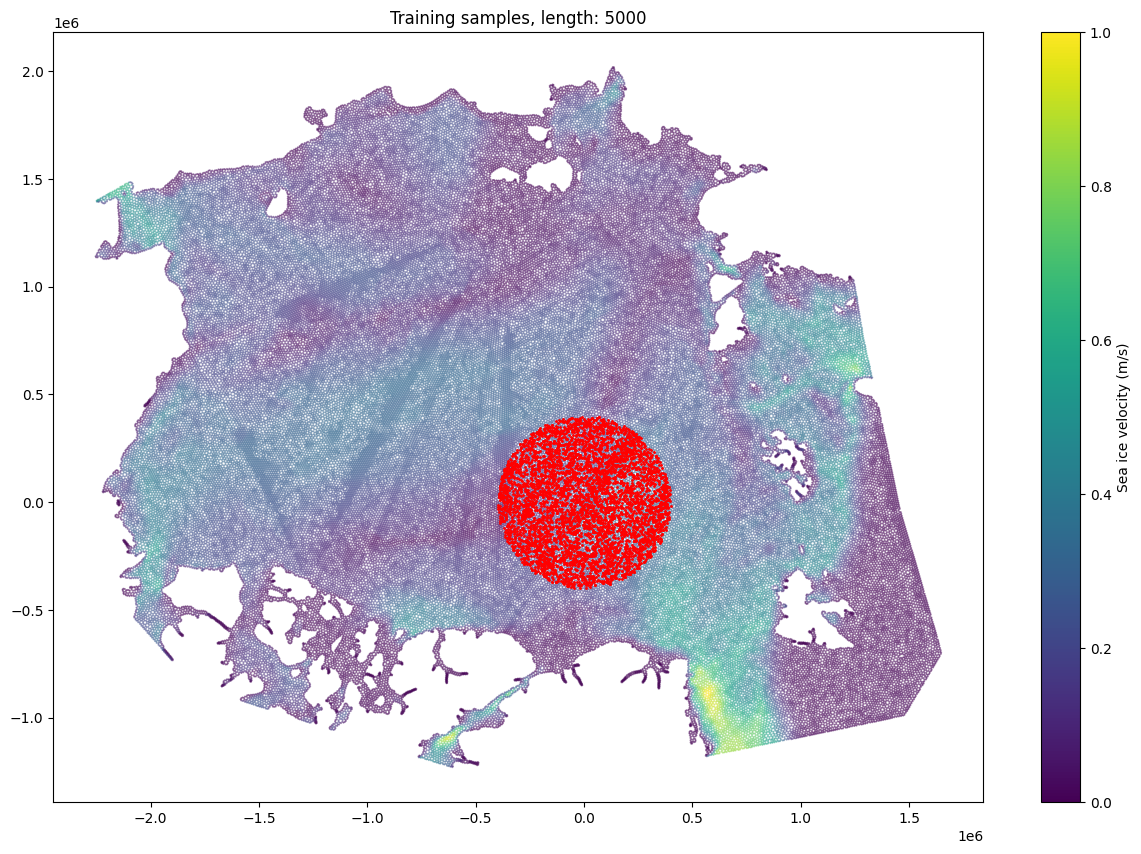

In [4]:
#Load the files (Note, you need to clone the repo first -- upper cells)
file_graphs = [dict(np.load(f'../example_data/{file}')) for file in sorted(os.listdir('../example_data')) if file[-3:]=='npz']
nextsim = Ice_graph(
    file_graphs,
    vertex_element_features =
        ['M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'M_VT_x',
        'M_VT_y',
        'x',
        'y']
)

#Here we can generate samples from an hour snapshot to create a training dataset
#We can either select randomly or within a radious from a given element.
#seed for reproducibility
np.random.seed(42)


n_generations = 5000

radius = 400000 #meters
n_neighbours = 4
iterations = 5
time_index = 6 #index of element graph to fetch samples from
val_time_index = time_index+iterations

samples_train = nextsim.get_samples_area((0,0),radius,time_index=time_index,n_samples=n_generations)
samples_val = nextsim.get_samples_area((0,0),radius,time_index=val_time_index,n_samples=int(n_generations/4)) #just 1/4 of items for validation

selected_graph = nextsim.get_item(time_index) 

#plot area defined by radius
plt.figure(figsize=(15,10))
vel_norm = np.sqrt(selected_graph['M_VT_x']**2 + selected_graph['M_VT_y']**2)
plt.scatter(selected_graph['x'],selected_graph['y'],c=vel_norm, s= 3 ,marker='.',linewidths=.7,alpha=.4)
plt.title("Training samples, length: "+str(len(samples_train)))
plt.scatter(selected_graph['x'][samples_train],selected_graph['y'][samples_train], color='red',s= 7 ,marker='.',linewidths=.7)
plt.colorbar(label='Sea ice velocity (m/s)')


element_g = nextsim.get_element_graph(samples_train[400],time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,predict_element=True)
vertex_g = nextsim.get_vertex_graph(samples_train[400],time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,predict_element=False)


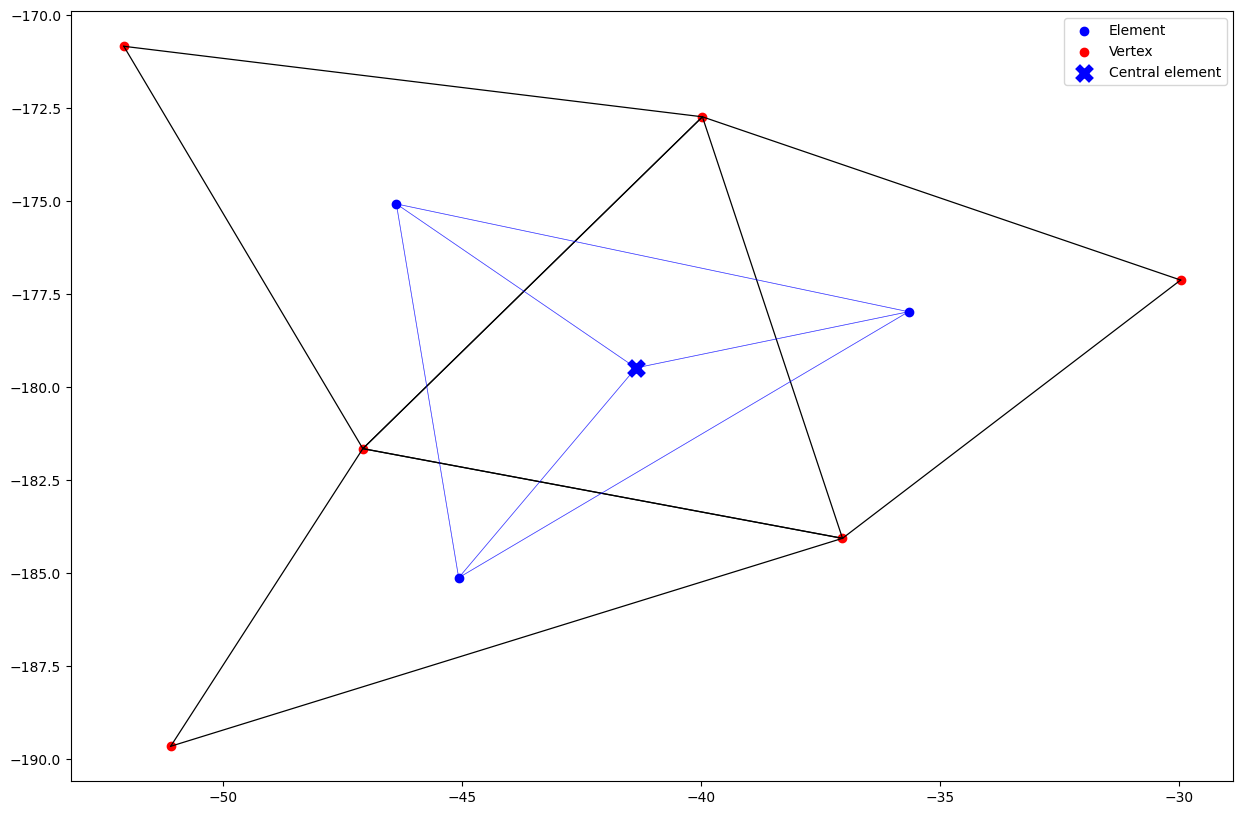

In [5]:
plt.figure(figsize=(15,10))
central_pos = selected_graph['x'][samples_train[400]]/1000,selected_graph['y'][samples_train[400]]/1000


for edge in vertex_g.edge_index.t():
    positions = np.array([vertex_g.pos.t()[edge[0]],vertex_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='black',linewidth=.9)

for edge in element_g.edge_index.t():
    positions = np.array([element_g.pos.t()[edge[0]],element_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='blue',linewidth=.5,alpha=.5)

plt.scatter(element_g.pos[0],element_g.pos[1],color='blue',label='Element')
plt.scatter(vertex_g.pos[0],vertex_g.pos[1],color='red',label='Vertex')

plt.scatter(central_pos[0],central_pos[1],marker='x', s=100, linewidth=5, c='blue', label='Central element')

plt.legend()

In [6]:
train_graph_list = []
fet = ['Damage', 'Concentration', 'Thickness', 'Sigma_0', 'Sigma_1', 'M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']
for sample in tqdm(samples_train,"Generating training graphs"):
    graph = nextsim.get_element_graph(sample,time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,features=fet,predict_element=True)
    if graph is not None:
        train_graph_list.append(graph)
        
val_graph_list = []
for sample in tqdm(samples_val,"Generating validation graphs"):
    graph = nextsim.get_element_graph(sample,time_index=val_time_index,n_neighbours=n_neighbours,target_iter=iterations,features=fet,predict_element=True)
    if graph is not None:
        val_graph_list.append(graph)

Generating validation graphs: 100%|██████████| 1250/1250 [00:05<00:00, 226.20it/s]


In [7]:
#standardize features
train_graph_list = standardize_graph_features(train_graph_list)
val_graph_list = standardize_graph_features(val_graph_list)

In [8]:
##DATASET AND MODEL DEFINITION

#Dataset: serves to fetch graph data on dataloaders or training loop. Its a standard torch class to manage information, transfrom and iterate over it
class Ice_graph_dataset(Dataset):
    def __init__(self, data_list, transform = None):
        super(Ice_graph_dataset, self).__init__()

        # List of graphs
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        if self.transform is not None:
            data.x = self.transform(data.x.unsqueeze(dim=0).moveaxis(-1,0)).squeeze().moveaxis(0,-1)

        return data
    
#Toy GNN model
class GCNN_node(nn.Module):

    def __init__(self, num_features, hidden_channels, output_size):
        super(GCNN_node, self).__init__()
        # conv layers as a test [WIP]
        self.conv1 = ChebConv(num_features, hidden_channels,K=1)
        self.fc = nn.Linear(hidden_channels, output_size)

    def forward(self, x, edge_index,edge_attr):
        x = self.conv1(x, edge_index,edge_attr)
        x = F.relu(x)

        # Global pooling to aggregate node features (... not sure how elegant)
        x = torch.mean(x, dim=0)

        # Fully connected layer for the final output
        x = self.fc(x)


        return x

In [9]:
# TRAINING LOOP

#create datasets and loaders
train_dataset = Ice_graph_dataset(train_graph_list, transform=None)
val_dataset = Ice_graph_dataset(val_graph_list, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

example_graph = next(iter(train_dataset)) #just to get the num_features

num_features = example_graph.x.shape[-1]  # Node feature dimension
hidden_channels = 12
num_classes = example_graph.y[0].shape[0] # trajectory lenght *2, since we have x,y.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNN_node(num_features, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = ExponentialLR(optimizer, gamma=0.9)
loss = nn.MSELoss()
num_epochs = 40

#trianing loop
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    training_loss = process_dataloader(model, train_dataloader, device, optimizer, scheduler, loss)
    training_losses.append(training_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {training_loss:.4f}")

    val_loss = process_dataloader(model, val_dataloader, device, criterion=loss)
    validation_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {val_loss:.4f}")

    scheduler.step() if scheduler else None



Epoch 1/40, Average Training Loss: 1786.5339
Epoch 1/40, Average Validation Loss: 124.6045
Epoch 6/40, Average Training Loss: 10.2833
Epoch 6/40, Average Validation Loss: 30.0329
Epoch 11/40, Average Training Loss: 2.3373
Epoch 11/40, Average Validation Loss: 15.0830
Epoch 16/40, Average Training Loss: 0.9023
Epoch 16/40, Average Validation Loss: 16.1720
Epoch 21/40, Average Training Loss: 0.4584
Epoch 21/40, Average Validation Loss: 16.4457
Epoch 26/40, Average Training Loss: 0.2903
Epoch 26/40, Average Validation Loss: 17.3723
Epoch 31/40, Average Training Loss: 0.2127
Epoch 31/40, Average Validation Loss: 13.7763
Epoch 36/40, Average Training Loss: 0.1818
Epoch 36/40, Average Validation Loss: 14.4880


(4926, 2)


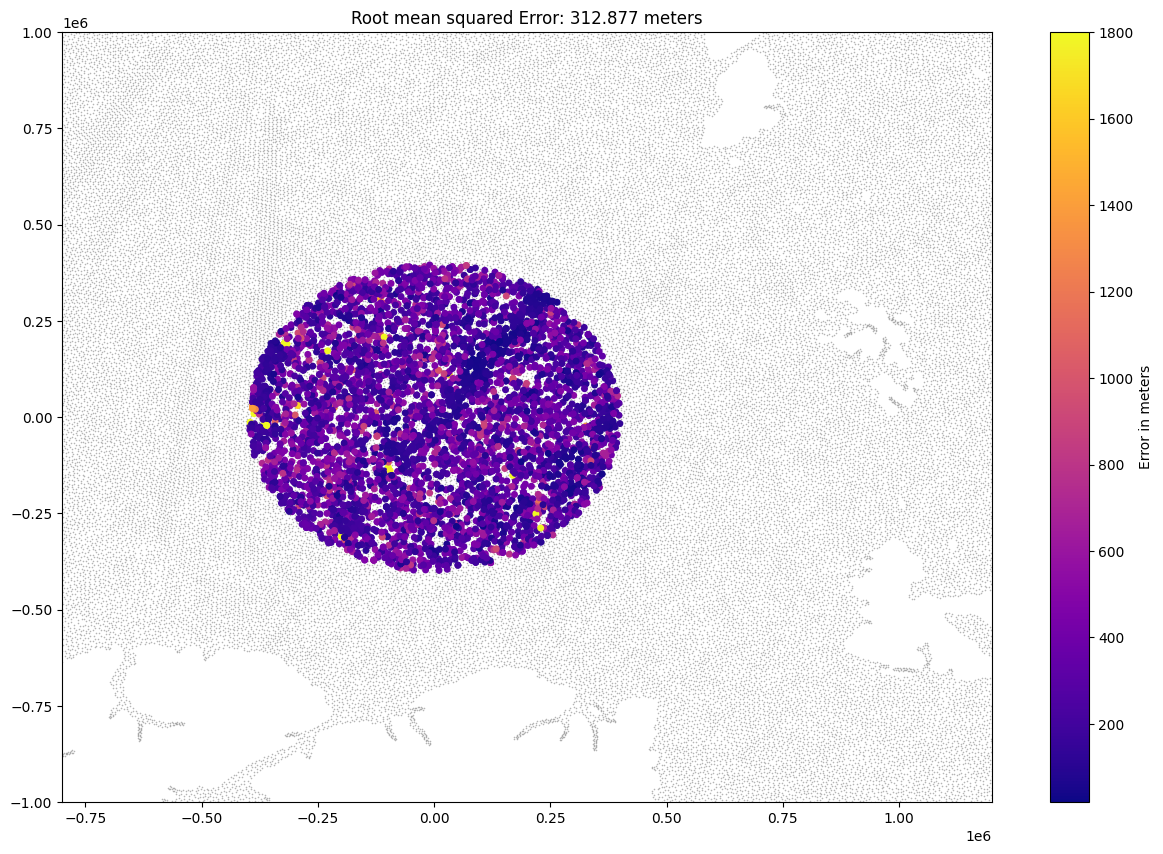

In [10]:
mse =  nn.MSELoss()
lossess = []
all_coords = []
for graph in train_dataset:
        graph = graph.to(device)
        output = model(graph.x, graph.edge_index, graph.edge_attr)
        loss = torch.sqrt(mse(output, graph.y[0])).to('cpu').detach().numpy() *1000
        coords = graph.y[-1]
        lossess.append(loss)
        all_coords.append(coords)

avg_loss = np.array(lossess).mean()
all_coords = np.stack(all_coords)*1000

print(all_coords.shape)
plt.figure(figsize=(15,10))
plt.scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
plt.scatter(all_coords[:,0],all_coords[:,1],c=np.clip(lossess,0,1800),s=16, cmap='plasma')
plt.xlim([-0.8e6, 1.2e6])
plt.ylim([-1e6, 1e6])
plt.title("Root mean squared Error: "+str(avg_loss-1)[:7]+" meters")
plt.colorbar( label="Error in meters")


/tmp/ipykernel_5424/1687646107.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lossess)


Text(0.5, 0, 'MAE (meters)')

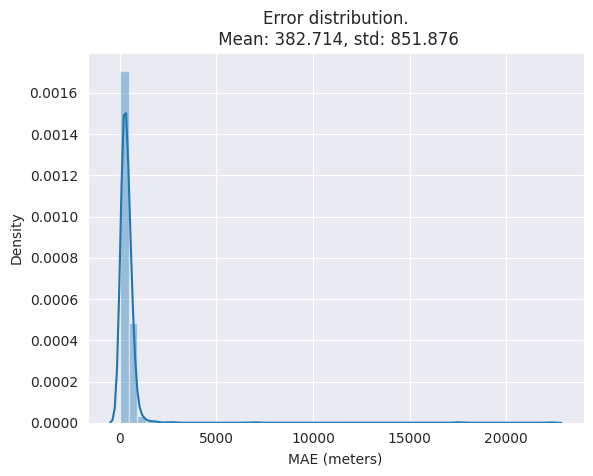

In [9]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(lossess)
plt.title(f"Error distribution.\n Mean: {str(avg_loss-1)[:7]}, std: {str(np.array(lossess).std())[:7]}")
plt.xlabel("MAE (meters)")


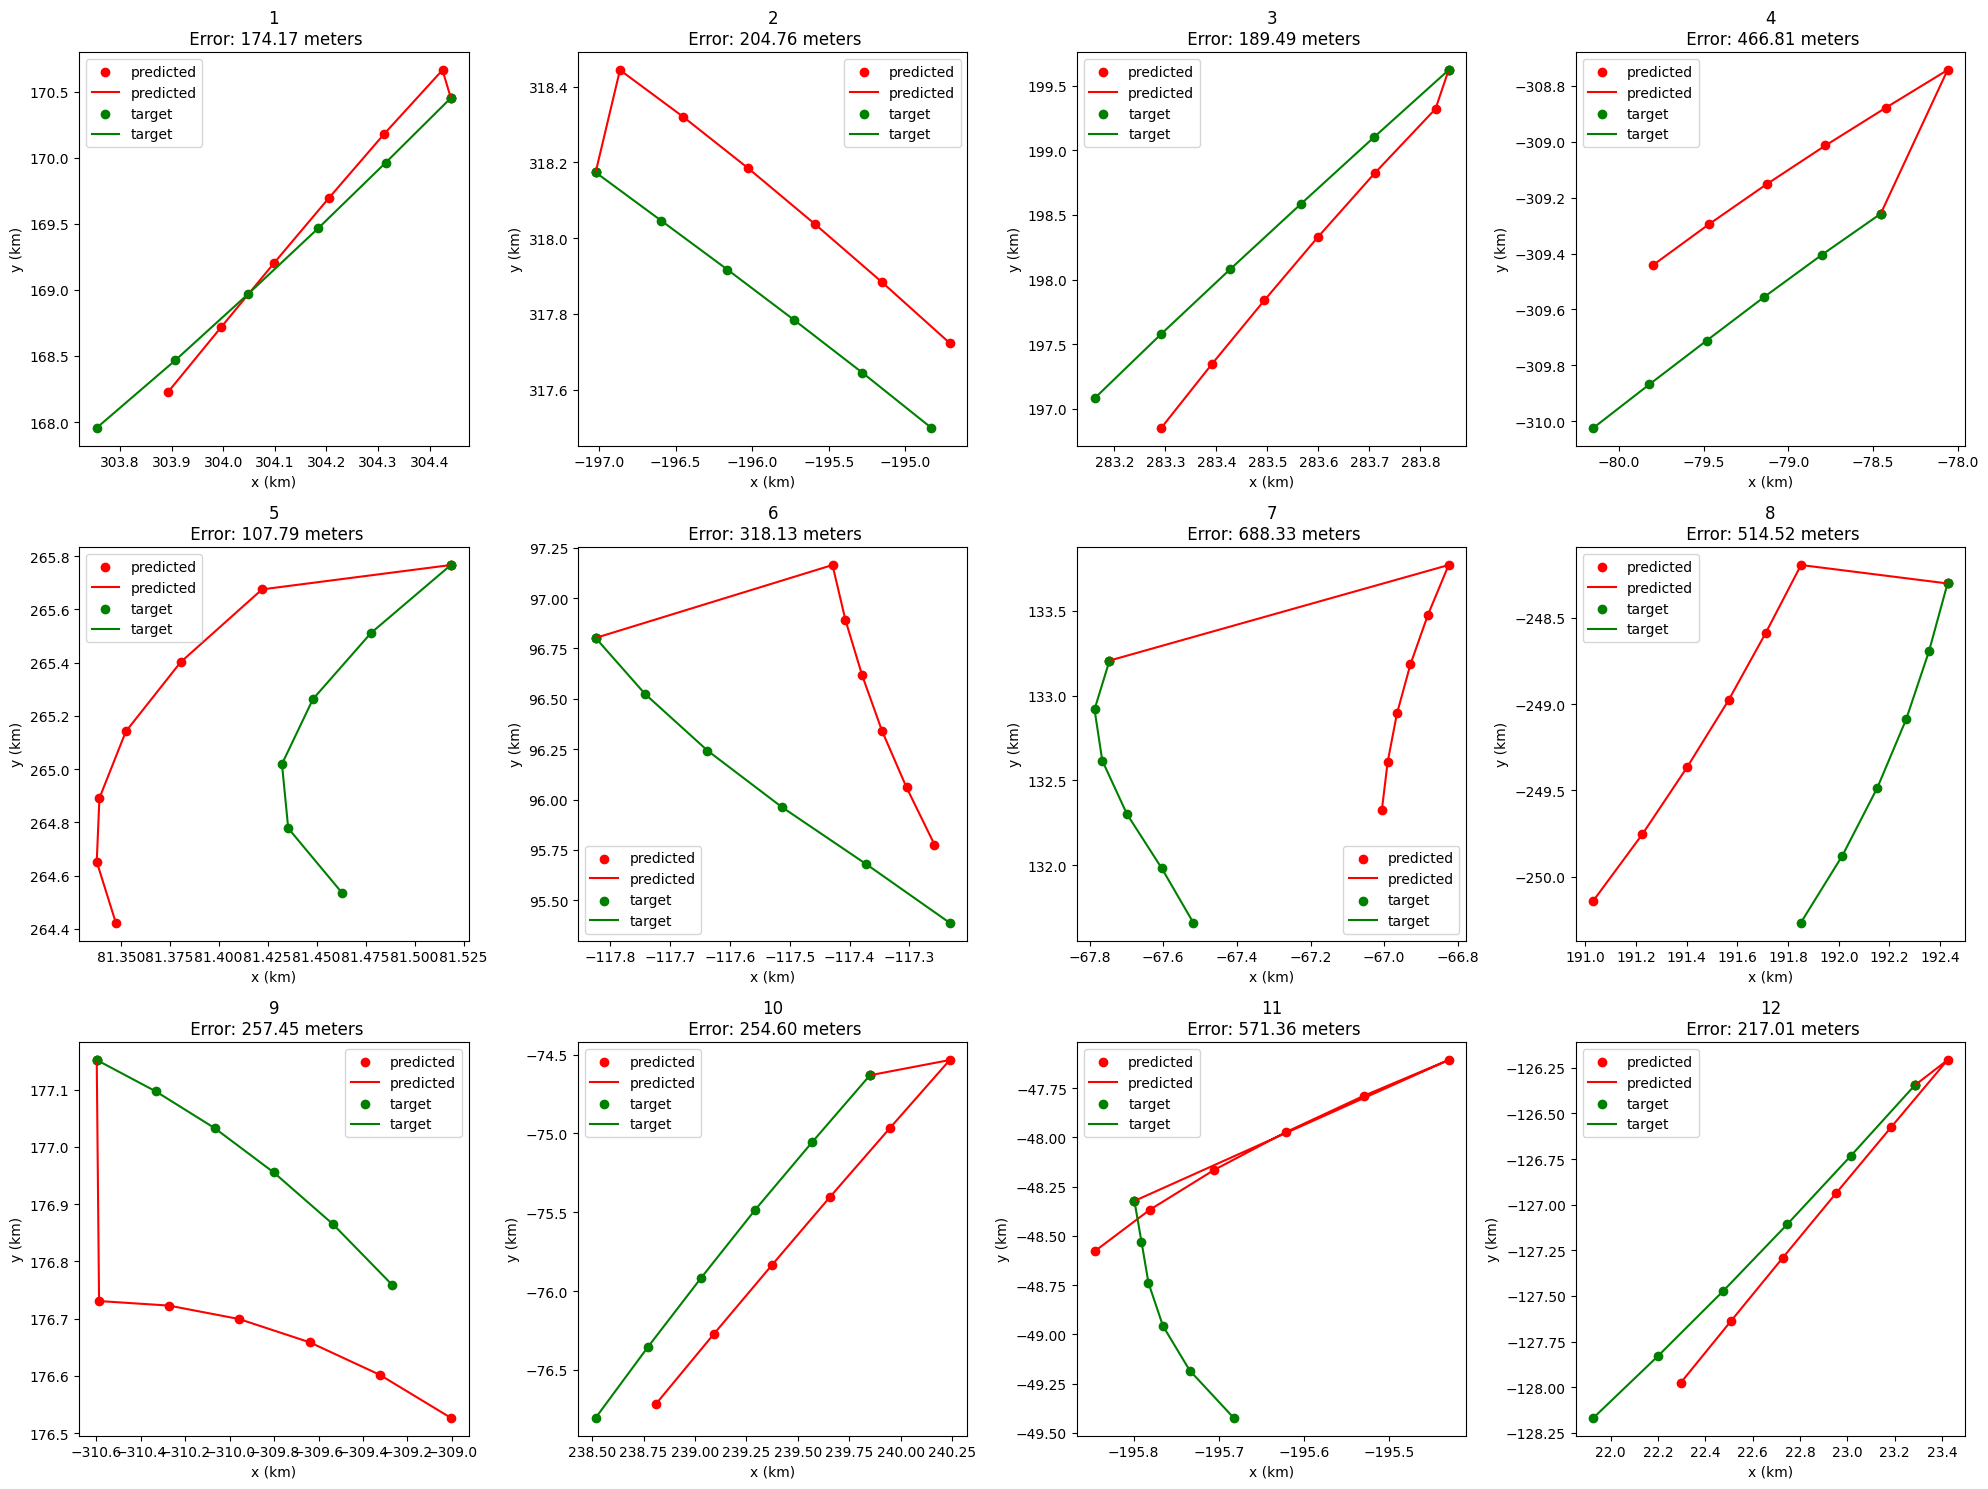

In [11]:
samples = [33, 222, 111,  666,
           333,4,44,555,
           341, 453, 23, 800]

target_iter = iterations+1
fig,axs = plt.subplots(3,4,figsize=(20,15))

for i,element in enumerate(samples):
    graph = train_graph_list[element]
    init_coords = graph.y[-1]
    graph = graph.to(device)

    output = model(graph.x, graph.edge_index, graph.edge_attr).cpu().detach().numpy()
    pred_x,pred_y = output[:target_iter],output[target_iter:]
    pred_x,pred_y = np.insert(pred_x,0,init_coords[0]), np.insert(pred_y,0,init_coords[1])

    target = graph.y[0].cpu().detach().numpy()
    target_x,target_y = target[:target_iter],target[target_iter:]
    target_x,target_y = np.insert(target_x,0,init_coords[0]), np.insert(target_y,0,init_coords[1])

    error = torch.sqrt(mse(torch.tensor(output),torch.tensor(target))).item()*1000
    
    axs.flatten()[i].scatter(pred_x,pred_y, c='red',label="predicted")
    axs.flatten()[i].plot(pred_x,pred_y, c='red',label="predicted")

    axs.flatten()[i].scatter(target_x,target_y, c='green',label="target")
    axs.flatten()[i].plot(target_x,target_y, c='green',label="target")

    #axs.flatten()[i].set_xlim([target_x[0]-10, target_x[0]+10]) # 10km
    #axs.flatten()[i].set_ylim([target_y[0]-10, target_y[0]+10])
    axs.flatten()[i].legend()
    axs.flatten()[i].set_title(f"{i+1}\n Error: "+str(error)[:6]+" meters")
    axs.flatten()[i].set_xlabel("x (km)")
    axs.flatten()[i].set_ylabel("y (km)")
plt.tight_layout()



In [119]:
def velocity_from_coords(coords:torch.tensor):
    """
    Function to compute velocity from coordinates

    Arguments:
        coords: torch.tensor
            coordinates of shape (n_samples,2,n_timesteps)
    Returns:
        vel: torch.tensor
            velocity of shape (2,n_timesteps-1)

    """
    us,vs = [],[]
    for i in range(coords.shape[-1]-1):
        u = (coords[:,0,i] - coords[:,0,i+1]) / (1 * 60 * 60)
        v = (coords[:,1,i] - coords[:,1,i+1]) / (1 * 60 * 60)
        us.append(u)
        vs.append(v)
    vs = torch.tensor(vs)
    us = torch.tensor(us)
    return torch.stack([us,vs])

def velocity_norm(velocity: torch.tensor):
    """
    Function to compute velocity norm

    Arguments:
        velocity: torch.tensor
            velocity of shape (2,n_timesteps,samples)
    Returns:
        vel: torch.tensor
            norm of shape (n_timesteps,samples)

    """
    return torch.norm(velocity[0,:,:]**2 + velocity[1,:,:]**2)

def velocity_angle(pred_vel,target_vel: torch.tensor):
    """
    Function to compute velocity angle between prediction and target tensors

    Arguments:
        pred_vel: torch.tensor
            velocity of shape (2,n_timesteps,samples)
         pred_vel: torch.tensor
            velocity of shape (2,n_timesteps,samples)
    Returns:
        angle: torch.tensor
            norm of shape (n_timesteps,samples)

    """
    unit_pred_vel = pred_vel / velocity_norm(pred_vel)
    unit_target_vel = target_vel / velocity_norm(target_vel)
    # Perform element-wise multiplication followed by sum along the second dimension
    dot_products = torch.clip(torch.sum(unit_pred_vel * unit_target_vel, dim=0),-1.0,1.0)
    angles = torch.acos(dot_products) * 180 / np.pi #to degrees
    return angles

In [24]:
lossess = []
target_coords = []
predicted_coords = []
for graph in train_dataset:
        graph = graph.to(device)
        output = model(graph.x, graph.edge_index, graph.edge_attr).cpu().detach().numpy()
        target = graph.y[0].cpu().detach().numpy()
        target_coords.append([target[:6],target[6:]]) #target
        predicted_coords.append([output[:6],output[6:]]) #predicted

target_coords = torch.tensor(target_coords)*1000
predicted_coords = torch.tensor(predicted_coords)*1000

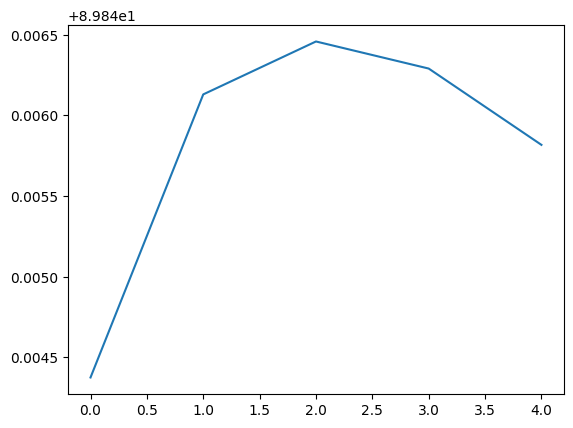

In [123]:
mse =  nn.MSELoss(reduction='none')
mae = nn.L1Loss(reduction='none')
#error over position
rmse_leads = torch.sqrt(torch.mean(mse(target_coords,predicted_coords),dim=[0,1]))
#error over velocity
target_vel = velocity_from_coords(np.array(target_coords))
predicted_vel = velocity_from_coords(np.array(predicted_coords))
#speed
target_vel_norm = velocity_norm(target_vel)
predicted_vel_norm =  velocity_norm(predicted_vel)
mae_vel_norm = torch.mean(mae(target_vel_norm,predicted_vel_norm),dim=[-1])
#angle
angles = velocity_angle(predicted_vel,target_vel)
angle_leads = torch.mean(angles,dim=-1)
plt.plot(angle_leads)

In [44]:
predicted_vel.shape

torch.Size([2, 5, 4926])

In [73]:
unit_pred_vel.shape

torch.Size([2, 5, 4926])

In [111]:
unit_pred_vel = predicted_vel / predicted_vel_norm
unit_target_vel = target_vel / target_vel_norm
# Perform element-wise multiplication followed by sum along the second dimension
dot_products = torch.clip(torch.sum(unit_pred_vel * unit_target_vel, dim=0),-1.0,1.0)
angles = torch.acos(dot_products) * 180 / np.pi
angles

tensor([[15.0856, 20.5754,  2.7849,  ...,  5.8699,  7.1365,  1.5115],
        [ 1.3310, 17.3367,  3.1558,  ...,  6.1870,  6.8066,  2.2676],
        [14.1117, 15.3259,  3.3143,  ...,  5.1346,  6.4257,  3.7342],
        [18.5518, 13.7071,  4.1842,  ...,  3.9309,  4.9690,  4.5657],
        [20.4659, 12.8914,  4.5767,  ...,  2.2183,  4.2663,  5.3167]])

In [17]:
xs = train_dataset[0].y[0][:6]*1000
ys = train_dataset[0].y[0][6:]*1000

for i in range(xs.shape[0]-1):
    u = (xs[i] - xs[i+1]) / (1 * 60 * 60)
    v = (ys[i] - ys[i+1]) / (1 * 60 * 60)

u,v

(tensor(-0.0751), tensor(0.0464))